# 离群点分析与异常检测

- 姓名：郝家辉
- 学号：3220190804
- 项目地址：https://github.com/AdamFocus/OutlierDetection

### 选择abalone和skin 两个数据集，对其使用多种算法进行离群点分析，并对比找出最优算法
### 报告描述整个流程，具体的python代码见outlier.py和analyse.py

## 1.导入相关库

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import os
import sys

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

import pickle
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

### 使用pyod中的离群点分析算法

In [3]:
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

## 2.数据集分析和预处理

**分别查看两个数据集：**
1. abalone数据集

benchmark数据集中包含以下项：
- point.id
- motherset
- origin,original.label
- diff.score
- ground.truth
- V1,V2,V3,V4,V5,V6,V7
2. skin数据集

benchmark数据集中包含以下项：
- point.id
- motherset
- origin,original.label
- diff.score
- ground.truth
- R,G,B

**去除point.id/motherset/origin/origin.label/diff.score**

### 数据处理如下

In [4]:
def pre_process(data):

    data.drop(['point.id', 'motherset', 'origin'], axis=1, inplace=True)
    data['ground.truth'] = data['ground.truth'].map({'nominal': 0, 'anomaly': 1})

    label = pd.get_dummies(data['original.label'], prefix='original.label')
    data.drop('original.label', inplace=True, axis=1)

    data = pd.concat((data, label), axis=1)

    y = data['ground.truth']
    X = data.drop('ground.truth', axis=1)
    
    return X, y

## 3.定义分类器

使用**ABOD,CBLOF,FB,HBOS,IF,KNN,AKNN,LOF,MCD,OCSVM,PCA**等方法定义分类器

设置离群点的分离度outliers_fraction

In [5]:
def load_classifiers(outliers_fraction):
    outliers_fraction = min(0.5, outliers_fraction)
    random_state = np.random.RandomState(42)
    
    classifiers = {
    'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                        random_state=random_state, behaviour="new"),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                   contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
    }
    return classifiers

## 4. 训练和测试

将outlier.py放于数据集文件夹中，并运行，代码细节如下：

1. 读取benchmarks文件夹中的所有csv文件
2. 为每个csv文件分别训练上面提到的多种分类器
3. 将每个分类器的roc_auc_score、f1_score、precision_score、recall_score保存到result文件夹中，方便接下来进行分析

In [ ]:
PATH = "benchmarks"
fns = os.listdir(PATH)

if not os.path.exists('result'):
    os.mkdir('result')

In [ ]:
for i in tqdm(range(len(fns))):
    fn = fns[i]
    
    if os.path.exists('result/{}'.format(fn)):
        continue

    data = pd.read_csv(os.path.join(PATH, fn))
    X, y = pre_process(data)
    
    outliers_fraction = y.sum()/len(y)
    classifiers = load_classifiers(outliers_fraction)
    
    all_scores = {}
    for i, (name, clf) in enumerate(classifiers.items()):
        try:
            clf.fit(X)
            y_pred = clf.predict(X)

            scores = []
            scores.append(roc_auc_score(y, y_pred))
            scores.append(f1_score(y, y_pred))
            scores.append(precision_score(y, y_pred))
            scores.append(recall_score(y, y_pred))
            all_scores[name] = scores
        except Exception as e:
            pass

    with open('result/{}'.format(fn), 'wb') as f:
        pickle.dump(all_scores, f,0)

## 5.对结果进行分析
计算每个分类器的平均指标，对比查看最优的分类器
### 5.1 abalone数据集
#### 读取生成的结果

In [9]:
PATH1 = "AbaResult"
fns1 = os.listdir(PATH1)

In [10]:
abaresult=[]

In [11]:
for i in range(len(fns1)):
    try:
        fn = fns1[i]
        with open(os.path.join('AbaResult', fn), 'rb') as f:
            score = pickle.load(f)
        
        for k, v in score.items():
            row = [fn, k] + v
            abaresult.append(row)
    except Exception as e:
        pass

In [12]:
abaresult = pd.DataFrame(abaresult, columns=['filename', 'models', 'roc', 'f1_score', 'precision', 'recall'])
abaresult.to_csv('Abaloneresult.csv', index=False)

#### 查看各指标的直方图

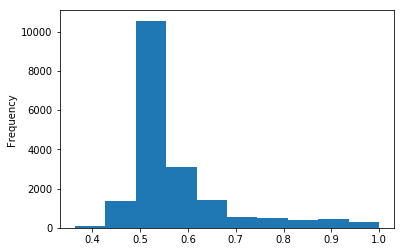

In [39]:
abaresult.roc.plot(kind='hist')

roc值主要分布于0.5到0.6之间

f1值，准确率和召回率都比较低

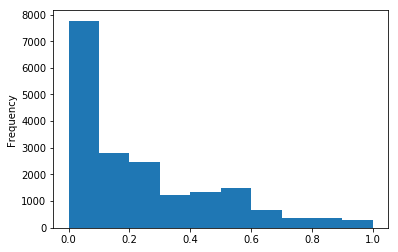

In [40]:
abaresult.f1_score.plot(kind='hist')

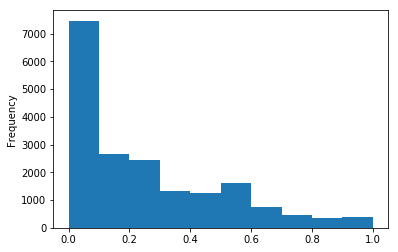

In [41]:
abaresult.precision.plot(kind='hist')

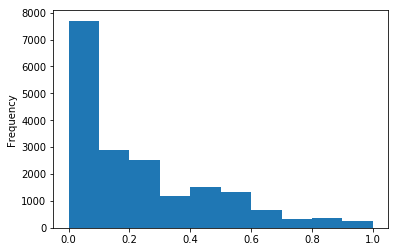

In [42]:
abaresult.recall.plot(kind='hist')

#### 对比查看模型的指标平均值

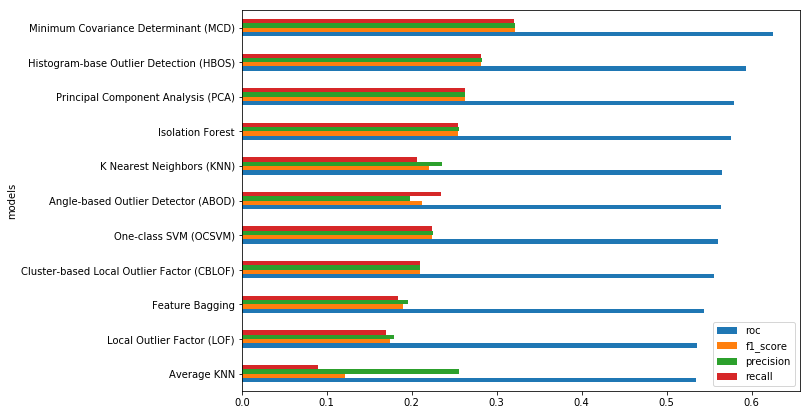

In [15]:
# 计算每个模型在所有文件上的指标平均值
roc1 = abaresult.groupby('models')['roc', 'f1_score', 'precision', 'recall'].apply(lambda x: x.mean())
# 按ROC值排序
roc1 = roc1.sort_values(by='roc')

roc1.plot.barh(figsize=(10, 7))

In [16]:
roc1

,roc,f1_score,precision,recall
models,,,,
Average KNN,0.534565,0.121323,0.255975,0.089372
Local Outlier Factor (LOF),0.535390,0.173840,0.179254,0.169134
Feature Bagging,0.543682,0.189509,0.196066,0.183772
Cluster-based Local Outlier Factor (CBLOF),0.556349,0.209987,0.210293,0.209687
One-class SVM (OCSVM),0.561029,0.224184,0.224477,0.223899
Angle-based Outlier Detector (ABOD),0.563670,0.212401,0.198295,0.234193
K Nearest Neighbors (KNN),0.565099,0.220015,0.235920,0.206696
Isolation Forest,0.575406,0.254883,0.255160,0.254613
Principal Component Analysis (PCA),0.579931,0.262735,0.263015,0.262462


#### 分析：
1. 从roc角度来看，大部分方法都处于0.50到0.60之间，Minimum Covariance Determinant获得了最好的效果，达到了0.62。
2. 从准确率、召回率和F1值来看，各个方法的效果都不是很理想
3. 总的来说，Minimum Covariance Determinant和Histogram-base Outlier Detection的方法在Abalone数据集上取得相对较好的效果。
4. 所有的离群点分析方法效果都比较差的原因可能是在数据处理时丢弃掉original.label和diff.score，数据特征较少

### 5.2skin数据集
#### 读取生成的结果

In [27]:
PATH2 = "skinResult"
fns2 = os.listdir(PATH2)
skinresult=[]

In [29]:
for i in range(len(fns2)):
    try:
        fn = fns2[i]
        with open(os.path.join('skinResult', fn), 'rb') as f:
            score = pickle.load(f)
        
        for k, v in score.items():
            row = [fn, k] + v
            skinresult.append(row)
    except Exception as e:
        pass

In [30]:
skinresult = pd.DataFrame(skinresult, columns=['filename', 'models', 'roc', 'f1_score', 'precision', 'recall'])
skinresult.to_csv('Skinresult.csv', index=False)

#### 查看各指标的直方图

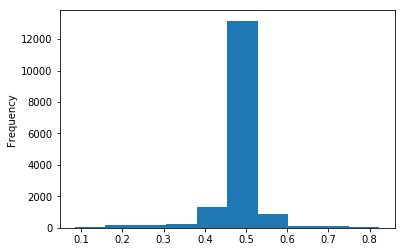

In [38]:
skinresult.roc.plot(kind='hist')

roc值主要分布于0.5左右

f1值，准确率和召回率都比较低

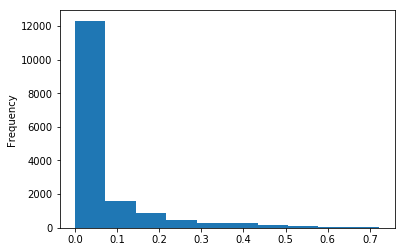

In [44]:
skinresult.f1_score.plot(kind='hist')

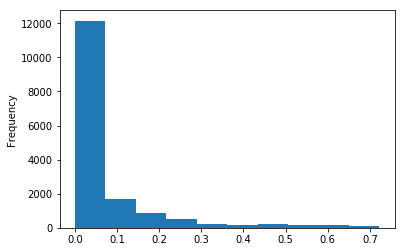

In [45]:
skinresult.precision.plot(kind='hist')

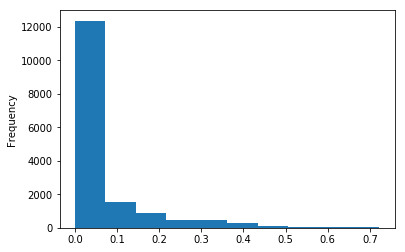

In [46]:
skinresult.recall.plot(kind='hist')

#### 对比查看模型的指标平均值

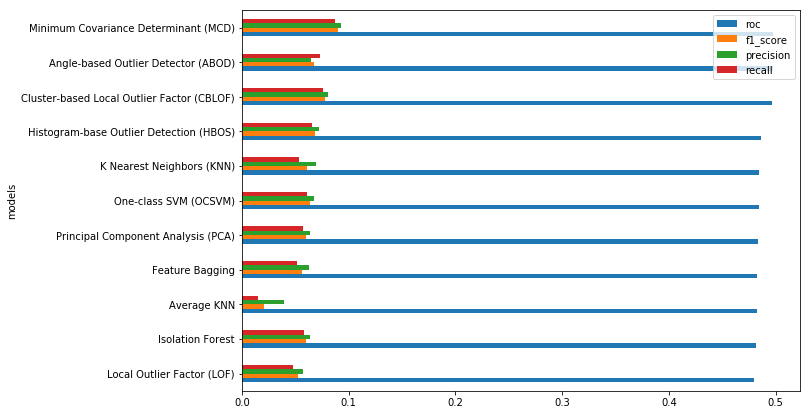

In [32]:
# 计算每个模型在所有文件上的指标平均值
roc2 = skinresult.groupby('models')['roc', 'f1_score', 'precision', 'recall'].apply(lambda x: x.mean())
# 按ROC值排序
roc2 = roc2.sort_values(by='roc')

roc2.plot.barh(figsize=(10, 7))

In [33]:
roc2

,roc,f1_score,precision,recall
models,,,,
Local Outlier Factor (LOF),0.479566,0.052245,0.057698,0.048218
Isolation Forest,0.481245,0.060463,0.063988,0.057964
Average KNN,0.482383,0.020314,0.039400,0.015020
Feature Bagging,0.482421,0.056488,0.062928,0.051781
Principal Component Analysis (PCA),0.483128,0.060119,0.064154,0.057258
One-class SVM (OCSVM),0.484283,0.063548,0.067345,0.060857
K Nearest Neighbors (KNN),0.484346,0.060606,0.069880,0.053897
Histogram-base Outlier Detection (HBOS),0.486768,0.068156,0.072188,0.065285
Cluster-based Local Outlier Factor (CBLOF),0.497022,0.078025,0.080730,0.076107


#### 分析：
1. 相较于Abalone数据集，skin数据集进行离群点分析的效果更差
2. 从准确率、召回率和F1值来看，各个方法的效果都不是很理想，但根据两个实验，MCD的方法更适合离群点分析
3. 针对Skin数据集，MCD/ABOD/CBLOF效果相近